In [2]:
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline
rng = np.random.default_rng()

# The Elastic Net

A problem with the LASSO appears when we consider correlated design matrices.

Take $d = 2$, and consider a setting where $X^{(i)}_1 = X^{(i)}_2$ for all $i$.

1. What happens to the objective
$$\hat\beta_t \in \underset{|\beta|_1 \leq t}{\arg\min}\,  \|Y - X\beta\|^2 ?$$

2. What if the constraint is replaced by $|\beta|_2 \leq t$ instead?

In [4]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Simulate correlated data
rng = np.random.default_rng(seed=42)
n_samples, n_features = 100, 2
X = rng.normal(size=(n_samples, 1))  # Single feature
X = np.hstack([X, X])  # Create two perfectly correlated features
y = 3 * X[:, 0] + 0.1 * rng.normal(size=n_samples)  # Target with small noise

In [5]:
# Fit Lasso
lasso = Lasso(alpha=0.1).fit(X, y)

# Fit Ridge
ridge = Ridge(alpha=0.1).fit(X, y)

print("LASSO coefficients:", lasso.coef_)
print("Ridge coefficients:", ridge.coef_)

LASSO coefficients: [2.84446803 0.        ]
Ridge coefficients: [1.50469893 1.50469893]


In [6]:
# Fit Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X, y)

print("Elastic Net coefficients:", elastic_net.coef_)

Elastic Net coefficients: [1.40606339 1.40453506]


Let's visualize how LASSO and Ridge perform with correlated features

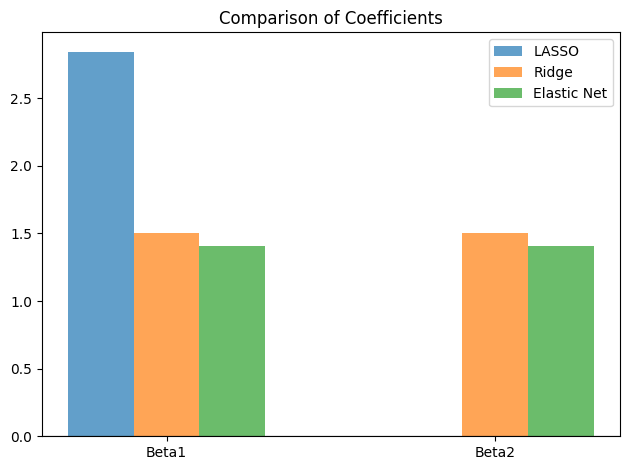

In [8]:
# Plot the coefficients for LASSO, Ridge, and Elastic Net
x_labels = ["Beta1", "Beta2"]  # Simplify labels
x = np.arange(len(x_labels))  # Set positions for bars

plt.bar(x - 0.2, lasso.coef_, width=0.2, label="LASSO", alpha=0.7)
plt.bar(x, ridge.coef_, width=0.2, label="Ridge", alpha=0.7)
plt.bar(x + 0.2, elastic_net.coef_, width=0.2, label="Elastic Net", alpha=0.7)

# Formatting the plot
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, x_labels)  # Add simple x-axis labels
plt.title("Comparison of Coefficients")
plt.legend()
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

1. When $X_1 = X_2$, LASSO will arbitrarily choose one coefficient to be non-zero, leading to instability. Ridge handles this better by spreading the penalty across both coefficients.

2. Replacing $|\beta\|_1$ with $|\beta\|_2$ changes the geometry of the constraint (from a diamond to a circle). This alters the solution behavior, especially under correlation. Discuss these differences using the plots.

### An illustration on synthetic data

We illustrate this with a synthetic data example. For $n = 100$, we draw $Z_{1}, Z_{2} \sim \mathcal{N}(0, I_n)$, and we define the data matrix $X \in \mathbb{R}^{100 \times 6}$ as:
- For $i = 1, 2, 3$
$$X_i = Z_1 + \xi_i/5, \quad \xi_i \sim \mathcal{N}(0, I_n)$$
- For $i = 4, 5, 6$,
$$X_i = Z_2 + \xi_i/5, \quad \xi_i \sim \mathcal{N}(0, I_n)$$

3. Simulate the above dataset, and compute the eigenvalues of $X$. What do you notice ?

4. Consider the regression model
$$ Y = X_1 + X_2 + X_3 - \frac{X_4 + X_5 + X_6}{2} + 2\epsilon, \quad \epsilon \sim \mathcal{N}(0, I_n). $$

Plot the lasso paths for this model, running the experiment a few times. What do you see?

[0.02680937 0.03121266 0.03989553 0.05682697 2.93807745 3.37620794]


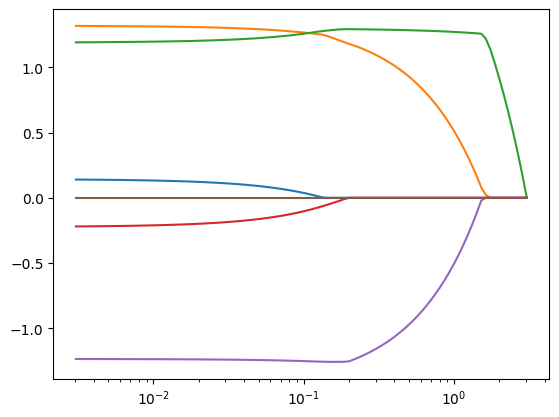

In [11]:
n = 100
Z = rng.standard_normal((n, 2))
X = np.zeros((n, 6))
for i in range(3):
  X[:, i] = Z[:, 0] + 1/5 * rng.standard_normal(n)
  X[:, i+3] = Z[:, 1] + 1/5 * rng.standard_normal(n)

eigvals = np.linalg.eigvalsh(np.cov(X.T))
Y = X @ [1, 1, 1, -1/2, -1/2, -1/2] + 2 * rng.standard_normal(n)
alphas, paths, _ = linear_model.lasso_path(X, Y)

print(eigvals)
plt.semilogx(alphas, paths.T)
plt.show()

3. The eigenvalues of the covariance matrix of X are: [0.03073736, 0.03467197, 0.03837371, 0.04603008, 3.01549673, 3.58122456]
   The two largest eigenvalues (3.015 and 3.581) are significantly larger than the remaining ones, which are much smaller (ranging from0.030 to 0.046). This indicates that the data matrix X is effectively low-rank, with most of the variance being captured by two principal components. This happens because X1, X2, X3 are derived from Z1, and X4, X5, X6 are derived from Z2, leading to high multicollinearity among the features.

5. When running the LASSO path multiple times, significant variability is observed in the selected features. This occurs due to the multicollinearity between X1, X2, X3 (derived from Z1) and X4, X5, X6 (derived from Z2), which makes it difficult for LASSO to distinguish between them. Additionally, the noise term in Y introduces further instability. As a result, LASSO often selects different subsets of features across different runs, demonstrating that it struggles in scenarios with high multicollinearity and noisy targets.


## The Elastic-net objective

To solve this unstability issue, we introduce an objective with a mix of $\ell^1$ and $\ell^2$ penalties:

$$\hat\beta_{\lambda, \alpha} = \underset{\beta\in\mathbb{R}^d}{\arg\min}\,  \|Y - X\beta\|^2 + \lambda(\alpha |\beta|_1 + (1 - \alpha)|\beta|_2^2)$$

5. What do the cases $\alpha = 0$ and $\alpha = 1$ correspond to?

6. Using the function [`enet_path`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.enet_path.html), compute the regularization paths for the Elastic-net objective, taking $\alpha = 0.3$. What changes?

_Be careful which parameter corresponds to $\lambda$ and $\alpha$!_

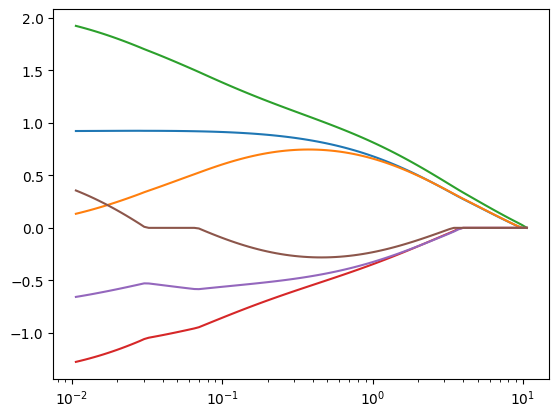

In [14]:
from sklearn.linear_model import enet_path

n = 100
Z = rng.standard_normal((n, 2))
X = np.zeros((n, 6))
for i in range(3):
  X[:, i] = Z[:, 0] + 1/5 * rng.standard_normal(n)
  X[:, i+3] = Z[:, 1] + 1/5 * rng.standard_normal(n)

# np.linalg.eigvalsh(np.cov(X.T))
Y = X @ [1, 1, 1, -1/2, -1/2, -1/2] + 2 * rng.standard_normal(n)
alphas, paths, _ = linear_model.enet_path(X, Y, l1_ratio=0.3)

plt.semilogx(alphas, paths.T)
plt.show()

5. The two cases represent the extremes of the Elastic Net regularization. When the parameter alpha equals zero, the model corresponds to Ridge regression. Ridge regression applies a penalty that shrinks the magnitude of the coefficients without reducing any of them to exactly zero. This means that all predictors are retained in the model, but their overall influence is reduced. This approach is particularly helpful in situations where predictors are highly correlated, as it distributes the penalty evenly across them to address multicollinearity.
On the other hand, when alpha equals one, the model corresponds to LASSO regression. LASSO applies a penalty that encourages sparsity by driving some coefficients to exactly zero. This has the effect of performing feature selection, retaining only the most important predictors while discarding the less relevant ones. This is particularly useful when the model is believed to rely on only a few important features.

6. When using alpha equal to 0.3 in the Elastic Net objective, the model combines elements of both Ridge and LASSO regression. This hybrid approach incorporates a penalty that promotes sparsity by shrinking some coefficients to zero, similar to LASSO, while also stabilizing the model by evenly distributing the penalty across correlated predictors, similar to Ridge. This makes Elastic Net especially useful in datasets where there is multicollinearity or where some predictors are redundant.
In the regularization paths generated with alpha set to 0.3, the coefficients show smooth and gradual transitions as the regularization parameter increases. Unlike LASSO, which often causes coefficients to drop abruptly to zero, Elastic Net introduces a more balanced and stable shrinkage of the coefficients. This balance between feature selection and stability makes Elastic Net effective for addressing both feature redundancy and overfitting, especially in datasets with a mix of important and irrelevant predictors.